# Capstone Project

## Abstract
The problem that I am seeking to address is that I have been tasked with creating a tool that can visualize different facets of stock market data in an interactive and simple way.  It must include predictions using machine learning, and should present clear and understandable visuals.  

My solution was to create a tool in Python, making use of both the widgets and plotly libraries.  Rather than including any code input, the interface can be operated with a few drop-down boxes.  It is also interactive, with scalable date ranges and values appearing when hovered over.  It presents a wide range of analytical insight on stocks, sectors, and yield rates.   

## Introduction
The business care here is a bit different than previous projects.  Rather than focusing solely on an in depth analysis of the data in order to answer a question, my goal is to create a data tool and incorporate the analysis into that. Specifically, I would like to create an interface that provides a wealth of information about stock market prices.  It should be simple to use and provide a high level of interactivity.  As this is a data science project, there will also be an emphasis on machine learning and how it could be used to predict future prices.  Additionally, there were two specific topics I wanted to examine and visualize, these were yield rates and economic sectors.

In [1]:
#Importing the necessary packages
import re
import os
import math
from io import StringIO
from datetime import datetime, timedelta, date
import requests
import pandas as pd
import numpy as np
import random
import statistics as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
from math import sqrt, log
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from ipywidgets import widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
#Creating a class in order to scrape data from Yahoo Finance
class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [3]:
#Defining a root mean squared error function for later
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(round(rmse, 3)))

In [4]:
#importing stock exchange datasets
nasdaq_df = pd.read_csv('nasdaq_list.csv')
nyse_df = pd.read_csv('nyse_list.csv')
nasdaq_df['exchange'] = 'nasdaq'
nyse_df['exchange'] = 'nyse'
comb_names = pd.concat([nyse_df, nasdaq_df], ignore_index=True)
comb_names.rename(str.lower, axis='columns', inplace=True)

# Data Cleaning / Feature Engineering

In [5]:
#Listing and dropping duplicates
dupe_list = comb_names.duplicated(subset=['symbol'])
dupes = []
for x in range(len(dupe_list)):
    if dupe_list[x] == True:
        dupes.append(x)
new_names = comb_names.drop(dupes)
new_names.reset_index(drop=True, inplace=True)

In [6]:
#Data cleaning- filtering out small companies, dropping columns, 
#Dropping NA values
mid_cap = new_names.copy()
drop_list = []
for x in range(len(mid_cap['marketcap'])):
    cap_value = str(mid_cap['marketcap'][x])
    if cap_value[-1] == 'M':
        drop_list.append(x)
    elif cap_value[-1] == 'B' and cap_value[:3] == '$1.':
        drop_list.append(x)
mid_cap.drop(drop_list, inplace=True)
mid_cap = mid_cap[mid_cap['marketcap'].notna()]
mid_cap = mid_cap[mid_cap['sector'].notna()]
mid_cap = mid_cap.drop(columns=['ipoyear', 'lastsale', 'summary quote', 'industry'])
mid_cap.reset_index(drop=True, inplace=True)

In [ ]:
#Getting list of all symbols and using it to scrape the web for stock data
symbol_list = mid_cap['symbol']
for x in symbol_list:
    try:
        temp_df = YahooFinanceHistory(x, days_back=365).get_quote()
        temp_df['symbol'] = x
        if x == symbol_list[0]:
            new_df = temp_df
        else:
            new_df = pd.concat([new_df, temp_df], ignore_index=True)
    except:
        continue 

In [7]:
#can use this to import the data that was already exported
#since the web scraper takes a while
new_df = pd.read_csv('new_df.csv')
new_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol
0,2019-10-31,168.509995,168.559998,163.550003,164.990005,159.066010,2653100.0,MMM
1,2019-11-01,166.940002,170.149994,166.720001,170.089996,163.982880,2467400.0,MMM
2,2019-11-04,171.619995,175.000000,171.619995,174.899994,168.620193,4142800.0,MMM
3,2019-11-05,175.000000,175.460007,173.770004,175.270004,168.976898,2304300.0,MMM
4,2019-11-06,174.910004,175.000000,172.360001,174.000000,167.752502,3012900.0,MMM


In [8]:
#Dropping NaN stocks
midcap_data = new_df.copy()
na_stocks = midcap_data[midcap_data['Open'].isna()]
na_unique = na_stocks['symbol'].unique()
for x in na_unique:
    na_temp = midcap_data[midcap_data['symbol'] == x]
    midcap_data.drop(na_temp.index, inplace=True)

In [9]:
#Quick list of unique dates in the dataset
#Removing stocks that don't cover the full date range
date_list = np.array(midcap_data['Date'].unique(), dtype='datetime64[D]')
midcap_data['Date']= pd.to_datetime(midcap_data['Date'])
for x in midcap_data['symbol'].unique():
    temp_df = midcap_data[midcap_data['symbol']==x]
    if temp_df['Date'].min() > min(date_list):
        midcap_data.drop(temp_df.index, inplace=True)

In [10]:
#Making columns lowercase, removing spacing
df = midcap_data.copy()
df.rename(str.lower, axis='columns', inplace=True)
df.rename(columns={'adj close':'adj_close'}, inplace=True)
df = df.set_index(['symbol', 'date'])
df.head()

open        high         low       close   adj_close  \
symbol date                                                                     
MMM    2019-10-31  168.509995  168.559998  163.550003  164.990005  159.066010   
       2019-11-01  166.940002  170.149994  166.720001  170.089996  163.982880   
       2019-11-04  171.619995  175.000000  171.619995  174.899994  168.620193   
       2019-11-05  175.000000  175.460007  173.770004  175.270004  168.976898   
       2019-11-06  174.910004  175.000000  172.360001  174.000000  167.752502   

                      volume  
symbol date                   
MMM    2019-10-31  2653100.0  
       2019-11-01  2467400.0  
       2019-11-04  4142800.0  
       2019-11-05  2304300.0  
       2019-11-06  3012900.0

In [11]:
#Setting multiindex and adding two new columns
df['diff'] = 0
multi_index = pd.MultiIndex.from_tuples(df.index, names=['symbol', 'date'])
df.reindex(multi_index)
df.sort_index(level=['symbol','date'], ascending=True, inplace=True)
df['diff'] = df['close'] - df['open']
df['pct_change'] = df['diff'] / df['open'] *100
df.head()

open       high        low      close  adj_close  \
symbol date                                                                
A      2019-10-31  76.000000  76.120003  75.099998  75.750000  75.105080   
       2019-11-01  76.510002  77.349998  76.320000  76.970001  76.314690   
       2019-11-04  77.680000  77.849998  76.730003  76.739998  76.086647   
       2019-11-05  76.820000  76.910004  75.470001  75.550003  74.906784   
       2019-11-06  75.699997  75.940002  74.940002  75.790001  75.144737   

                      volume      diff  pct_change  
symbol date                                         
A      2019-10-31   970500.0 -0.250000   -0.328947  
       2019-11-01  1106300.0  0.459999    0.601227  
       2019-11-04  1010200.0 -0.940002   -1.210095  
       2019-11-05  2362700.0 -1.269997   -1.653211  
       2019-11-06  1355700.0  0.090004    0.118896

In [12]:
#Creating a moving average column
df['move_avg_7'] = 0
for x,y in df.index:
    if y >= df.index[4][1]:
        if y.weekday() != 4:
            first_day = y - timedelta(days=6)
            df.loc[(x, y),'move_avg_7'] = \
            df.loc[(x, first_day):(x, y), 'pct_change'].mean()
        elif y.weekday() == 4:
            first_day = y - timedelta(days=4) 
            df.loc[(x, y),'move_avg_7'] = \
            df.loc[(x, first_day):(x, y), 'pct_change'].mean()
        
df.head()

open       high        low      close  adj_close  \
symbol date                                                                
A      2019-10-31  76.000000  76.120003  75.099998  75.750000  75.105080   
       2019-11-01  76.510002  77.349998  76.320000  76.970001  76.314690   
       2019-11-04  77.680000  77.849998  76.730003  76.739998  76.086647   
       2019-11-05  76.820000  76.910004  75.470001  75.550003  74.906784   
       2019-11-06  75.699997  75.940002  74.940002  75.790001  75.144737   

                      volume      diff  pct_change  move_avg_7  
symbol date                                                     
A      2019-10-31   970500.0 -0.250000   -0.328947    0.000000  
       2019-11-01  1106300.0  0.459999    0.601227    0.000000  
       2019-11-04  1010200.0 -0.940002   -1.210095    0.000000  
       2019-11-05  2362700.0 -1.269997   -1.653211    0.000000  
       2019-11-06  1355700.0  0.090004    0.118896   -0.494426

In [13]:
#Finding the difference between each stock's start and end date
sym_list = list(df.index.get_level_values(0).unique())
delta_list = []
for x in sym_list:
    start_val = df.loc[(x, df.loc[x].index.min()), 'open']
    end_val = df.loc[(x, df.loc[x].index.max()), 'close'] 
    delta_list.append(end_val-start_val)
deltarray = np.array(delta_list)

In [14]:
#Creating a reference dataframe for time independent columns
sym_delta = pd.DataFrame({'symbol':sym_list, 'delta':deltarray})
sym_delta.set_index('symbol', drop=True, inplace=True)
new_midcap = mid_cap.set_index('symbol', drop=True)
sym_delta['sector'] = 0
sym_delta['exchange'] = 0
for x in sym_delta.index:
    sym_delta.loc[x,'sector'] = new_midcap.loc[x, 'sector']
    sym_delta.loc[x,'exchange'] = new_midcap.loc[x, 'exchange']
sym_delta.head()

,delta,sector,exchange
symbol,,,
A,26.019997,Capital Goods,nyse
AA,-8.190001,Basic Industries,nyse
AAL,-18.910000,Transportation,nasdaq
AAN,-21.980000,Technology,nyse
AAON,12.329998,Capital Goods,nasdaq


In [15]:
#Adding several new columns to the dataframe
df['delta'] = 0
df['delta_pct'] = 0
df['sector'] = 0
df['exchange'] = 0
for x in sym_delta.index:
    df.loc[x, 'delta'] = sym_delta.loc[x, 'delta']
    df.loc[x, 'sector'] = sym_delta.loc[x, 'sector']
    df.loc[x, 'exchange'] = sym_delta.loc[x, 'exchange']
    df.loc[x, 'delta_pct'] = sym_delta.loc[x, 'delta'] \
    / df.loc[(x, df.loc[x].index.min()), 'open'] *100

In [16]:
#Dropping columns used for calculations
#And other unneeded columns
df['intra_rng'] = df['high'] - df['low']
df['intra_pct'] = df['intra_rng'] / df['open'] *100
df.drop(columns=['high', 'low', 'adj_close', 'volume', 'diff', 'delta', 'intra_rng'], inplace=True)
df.head()

open      close  pct_change  move_avg_7  delta_pct  \
symbol date                                                                  
A      2019-10-31  76.000000  75.750000   -0.328947    0.000000  34.236838   
       2019-11-01  76.510002  76.970001    0.601227    0.000000  34.236838   
       2019-11-04  77.680000  76.739998   -1.210095    0.000000  34.236838   
       2019-11-05  76.820000  75.550003   -1.653211    0.000000  34.236838   
       2019-11-06  75.699997  75.790001    0.118896   -0.494426  34.236838   

                          sector exchange  intra_pct  
symbol date                                           
A      2019-10-31  Capital Goods     nyse   1.342112  
       2019-11-01  Capital Goods     nyse   1.346227  
       2019-11-04  Capital Goods     nyse   1.441806  
       2019-11-05  Capital Goods     nyse   1.874516  
       2019-11-06  Capital Goods     nyse   1.321004

In [17]:
#Creating a dataframe of only the last date
#Also making one for the first date
for x in sym_delta.index:
    open_val = pd.DataFrame(df.loc[(x, df.loc[x].index.min())]) 
    close_val = pd.DataFrame(df.loc[(x, df.loc[x].index.max())]) 
    if x == sym_delta.index[0]:
        open_df = open_val.T
        close_df = close_val.T
    else:
        open_df = pd.concat([open_df, open_val.T])
        close_df = pd.concat([close_df, close_val.T])
close_df.head()

,,open,close,pct_change,move_avg_7,delta_pct,sector,exchange,intra_pct
A,2020-10-29,102.27,102.02,-0.244451,-0.742499,34.2368,Capital Goods,nyse,2.23428
AA,2020-10-29,12.21,12.75,4.4226,-0.0552178,-39.1118,Basic Industries,nyse,5.24161
AAL,2020-10-29,10.96,11.16,1.82482,-2.11402,-62.8866,Transportation,nasdaq,3.64964
AAN,2020-10-29,54.95,54.76,-0.345774,-0.764469,-28.6422,Technology,nyse,7.91628
AAON,2020-10-29,57.1,58.98,3.29247,-0.07755,26.4309,Capital Goods,nasdaq,4.60596


In [18]:
#Creating a dataframe with summary statistics
pct_change_list = []
delta_pct_list = []
intra_pct_list = []
sector_summ_list = []
exchange_list = []
for x in sym_delta.index:
    pct_change_list.append(df.loc[x, 'pct_change'].mean())
    delta_pct_list.append(df.loc[x, 'delta_pct'].mean())
    intra_pct_list.append(df.loc[x, 'intra_pct'].mean())
    sector_summ_list.append(close_df.loc[x, 'sector'][-1])
    exchange_list.append(close_df.loc[x, 'exchange'][-1])
summ_val = {'pct_change':pct_change_list, \
           'delta_pct':delta_pct_list, \
           'intra_pct':intra_pct_list, \
           'sector':sector_summ_list, \
           'exchange':exchange_list}
summary_df = pd.DataFrame(summ_val, index=sym_delta.index)
summary_df.head()

,pct_change,delta_pct,intra_pct,sector,exchange
symbol,,,,,
A,0.123025,34.236838,2.376618,Capital Goods,nyse
AA,-0.210734,-39.111751,5.697919,Basic Industries,nyse
AAL,-0.580924,-62.886598,6.465470,Transportation,nasdaq
AAN,-0.142530,-28.642169,5.012361,Technology,nyse
AAON,0.179401,26.430863,3.699973,Capital Goods,nasdaq


In [19]:
#Creating a custom frequency by importing the Federal holidays
#And adding/subtracting the stock exchange dates
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=min(date_list), end=max(date_list))
updated_holidays = list(holidays)
updated_holidays.append(datetime(2020, 4, 10))
updated_holidays = np.array(updated_holidays, dtype='datetime64[D]')
updated_holidays = np.delete(updated_holidays, [0,9])
bday_us = pd.offsets.CustomBusinessDay(holidays=updated_holidays)
dt_index = pd.DatetimeIndex(date_list, freq=bday_us)

In [20]:
#Creating a quick list of sectors
sector_list = list(df['sector'].unique())
sector_list.sort()

In [21]:
#Storing sector averages in a dictionary
date_dict = {}
for x in sector_list:
    temp_subset = df[df['sector'] == x]
    dict_append = {}
    for y in date_list:
        temp_pct = []
        temp_intra = []
        temp_delta = []
        for z in temp_subset.index:
            if z[1] == y:
                temp_pct.append(temp_subset.loc[z, 'pct_change'])
                temp_intra.append(temp_subset.loc[z, 'intra_pct'])
                temp_delta.append(temp_subset.loc[z, 'delta_pct'])
        pct_mean = stats.mean(temp_pct)
        intra_mean = stats.mean(temp_intra)
        delta_mean = stats.mean(temp_delta)
        dict_append[y] = [pct_mean, intra_mean, delta_mean]
    date_dict[x] = dict_append

In [22]:
#Creating a new dataframe to hold sector averages
sector_df = pd.DataFrame.from_dict({(i,j): date_dict[i][j] 
                           for i in date_dict.keys() 
                           for j in date_dict[i].keys()},
                       orient='index', columns=['pct_change', 'intra_pct', 'delta_pct'])

In [23]:
#Creating a dictionary to split the tuple index
sect_index = []
date_index = []
for x,y in sector_df.index:
    sect_index.append(x)
    date_index.append(y)
index_dict = {'sector':sect_index, 'date':date_index}
index_df = pd.DataFrame(index_dict)

In [24]:
#Setting a multiindex for the sector_test dataframe
sector_test = sector_df.copy().reset_index(drop=True)
sector_test[['sector', 'date']] = index_df[['sector', 'date']]
sector_test = sector_test.set_index(['sector', 'date'])
new_index = pd.MultiIndex.from_tuples(sector_test.index, names=['sector', 'date'])
sector_test.reindex(new_index)
sector_test.sort_index(level=['sector','date'], ascending=True, inplace=True)
sector_test.head()

pct_change  intra_pct  delta_pct
sector           date                                        
Basic Industries 2019-10-31   -0.091392   3.308644  10.691496
                 2019-11-01    1.666739   3.289555  10.691496
                 2019-11-04    0.140195   2.575912  10.691496
                 2019-11-05    0.315045   3.054165  10.691496
                 2019-11-06    0.148136   2.881368  10.691496

In [25]:
#Creating a sector index
sector_test['sector_avg'] = 0
for x in sector_list:
    temp_frame = sector_test.loc[x]
    for y in temp_frame.index:
        if y == temp_frame.index[0]:
            sector_test.loc[(x,y), 'sector_avg'] = 100 
        else: 
            sector_test.loc[(x,y), 'sector_avg'] = sector_test.loc[(x,prev), 'sector_avg'] \
            + sector_test.loc[(x,prev), 'sector_avg'] * temp_frame.loc[y, 'pct_change'] / 100
        prev = y    

In [26]:
#importing yield data and combining it
yield_2019 = pd.read_csv('yield2019.tsv', sep='\t')
yield_2020 = pd.read_csv('yield2020.tsv', sep='\t')
yield_comb = pd.concat([yield_2019, yield_2020], ignore_index=True)
yield_comb.rename(str.lower, axis='columns', inplace=True)
yield_comb['date'] = pd.to_datetime(yield_comb['date'], infer_datetime_format=True)
yield_comb = yield_comb.set_index('date', drop=True)
yield_comb.head()

,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
date,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00


In [27]:
#Removing spacing from column names
new_cols = {}
for x in yield_comb.columns:
    new_x = x.replace(" ", "")
    new_cols[x] = new_x
yield_comb.rename(columns=new_cols, inplace=True)
yield_comb.head()

,1mo,2mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
date,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00


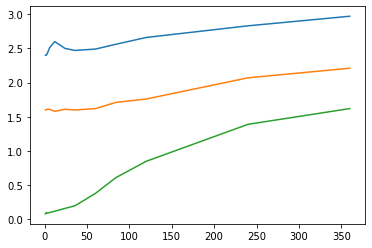

In [28]:
#plotting a quick example of some yield curves
time_lengths = [1, 2, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360]
plt.plot(time_lengths, yield_comb.iloc[0])
plt.plot(time_lengths, yield_comb.iloc[225])
plt.plot(time_lengths, yield_comb.iloc[-1])

In [29]:
yield_comb['10yr2yr'] = yield_comb['10yr'] - yield_comb['2yr']
yield_comb['30yr5yr'] = yield_comb['30yr'] - yield_comb['5yr']
yield_comb.head()

,1mo,2mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr,10yr2yr,30yr5yr
date,,,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97,0.16,0.48
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92,0.17,0.55
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98,0.17,0.49
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99,0.17,0.46
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00,0.15,0.42


In [30]:
#Dropping dates that fall outside my data range
drop_dates = []
for x in yield_comb.index:
    if x > max(date_list):
        drop_dates.append(x)
    elif x < min(date_list):
        drop_dates.append(x)
yield_comb.drop(drop_dates, inplace=True)

In [31]:
#Adding yield columns to the sector_dates dataframe
#Creating sector_values dataframe, contains the data for ARIMA
sector_dates = sector_test.copy()
sector_dates['10yr2yr'] = 0
sector_dates['30yr5yr'] = 0
for x in sector_list:
    temp_frame = sector_dates.loc[x]
    for y in temp_frame.index:
        if y in yield_comb.index:
            sector_dates.loc[(x,y),'10yr2yr'] = yield_comb.loc[y, '10yr2yr']
            sector_dates.loc[(x,y),'30yr5yr'] = yield_comb.loc[y, '30yr5yr']
        else: 
            sector_dates.loc[(x,y),'10yr2yr'] = yield_comb.loc[prev, '10yr2yr']
            sector_dates.loc[(x,y),'30yr5yr'] = yield_comb.loc[prev, '30yr5yr']
        prev = y
sector_values = sector_test.drop(columns=['pct_change', 'intra_pct', 'delta_pct'])

# Data Visualization
(Most of this is at the end with the interface)

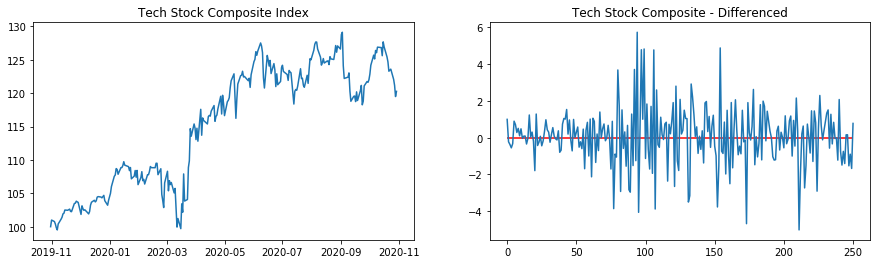

In [32]:
#Quick example of Box-Jenkins method, checking if data is stationary
tech_test = sector_values.loc['Technology']
tech_array = np.array(tech_test['sector_avg'])
tech_series = pd.Series(np.diff(tech_array))
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
axes[0].plot(tech_test.index, tech_test['sector_avg'], '-')
axes[0].set(title='Tech Stock Composite Index')

# Differenced data
axes[1].plot(tech_series.index, tech_series, '-')
axes[1].hlines(0, 0, 250, 'r')
axes[1].set(title='Tech Stock Composite - Differenced');

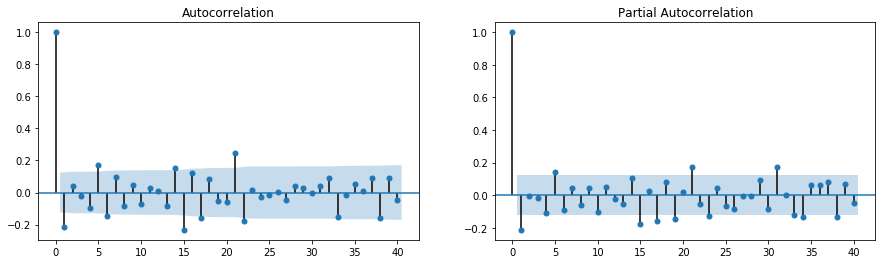

In [33]:
# Another example of Box-Jenkins, checking for AR
#Becomes zero at lag p+1 on Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(tech_series[1:], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(tech_series[1:], lags=40, ax=axes[1])

# Modeling - ARIMA

In [34]:
#Running all of the sector indices through auto_arima to find parameters
#Also returning all of the prediction results at the same time
order_dict = {}
results_dict = {}
pred_dict = {}
for x in sector_list:    
    temp_sector = sector_values.loc[x]
    temp_sector.index.freq=bday_us
    model = pm.auto_arima(temp_sector, max_p=8, max_d=4, max_q=8, seasonal=False, \
                          suppress_warnings=True, maxiter=200, error_action="ignore")
    model_dict = model.to_dict()
    order_dict[x] = [model_dict[y] for y in ['order','aic']]
    print(x +' = ARIMA {} : AIC Calculated = {}'.format(order_dict[x][0], order_dict[x][1]))
    
    results_dict[x] = model
    pred = model.predict_in_sample(start=180, return_conf_int=True)
    pred_vals = pred[0]
    pred_conf = pred[1]
    forecast = model.predict(5, return_conf_int=True)
    forecast_vals = forecast[0]
    forecast_conf = forecast[1]
    pred_dict[x] = [pred_vals, pred_conf, forecast_vals, forecast_conf]

Basic Industries = ARIMA (1, 1, 1) : AIC Calculated = 907.9728971041873
Capital Goods = ARIMA (1, 1, 1) : AIC Calculated = 908.0750002428197
Consumer Durables = ARIMA (0, 1, 1) : AIC Calculated = 927.4131270226571
Consumer Non-Durables = ARIMA (2, 1, 2) : AIC Calculated = 823.6474969341838
Consumer Services = ARIMA (2, 1, 2) : AIC Calculated = 872.3329599475859
Energy = ARIMA (2, 1, 2) : AIC Calculated = 1002.5862379560306
Finance = ARIMA (0, 1, 1) : AIC Calculated = 936.9821811883147
Health Care = ARIMA (0, 1, 1) : AIC Calculated = 949.3019344739881
Miscellaneous = ARIMA (2, 1, 3) : AIC Calculated = 918.1139836002662
Public Utilities = ARIMA (0, 1, 0) : AIC Calculated = 834.6216807442759
Technology = ARIMA (1, 1, 0) : AIC Calculated = 924.9076437411406
Transportation = ARIMA (1, 1, 0) : AIC Calculated = 815.7548127933538


In [35]:
#Creating a dataframe from the prediction dictionary
#That was produced by the ARIMA outputs
pred_df = pd.DataFrame.from_dict(pred_dict, orient='index', \
                                 columns=['pred_vals', 'pred_conf', 'forecast_vals', 'forecast_conf'])
for x in sector_list:
    test_values = sector_values.loc[x][180:]
    sector_preds = pred_df.loc[x, 'pred_vals']
    print(x), return_rmse(test_values,sector_preds)

Basic Industries
The root mean squared error is 1.081.
Capital Goods
The root mean squared error is 1.083.
Consumer Durables
The root mean squared error is 1.136.
Consumer Non-Durables
The root mean squared error is 0.899.
Consumer Services
The root mean squared error is 1.014.
Energy
The root mean squared error is 1.33.
Finance
The root mean squared error is 1.071.
Health Care
The root mean squared error is 1.286.
Miscellaneous
The root mean squared error is 1.179.
Public Utilities
The root mean squared error is 0.762.
Technology
The root mean squared error is 1.324.
Transportation
The root mean squared error is 0.884.


In [36]:
#Creating a dataframe that is easier to access later
sectval_dict = {}
for x in sector_list:
    sectval_temp = sector_values.loc[x]
    sectval_dict[x] = sectval_temp['sector_avg']
sectval_df = pd.DataFrame(data=sectval_dict)
sectval_df.reset_index(inplace=True)
sectval_df.head()

,date,Basic Industries,Capital Goods,Consumer Durables,Consumer Non-Durables,Consumer Services,Energy,Finance,Health Care,Miscellaneous,Public Utilities,Technology,Transportation
0,2019-10-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2019-11-01,101.666739,101.275366,100.338850,100.464400,100.290714,101.805902,100.671028,101.329830,100.169585,100.154803,100.994993,101.137108
2,2019-11-04,101.809270,101.274496,100.327128,99.823490,100.138426,103.182333,100.714505,100.925657,100.129724,99.390808,100.770713,102.049915
3,2019-11-05,102.130015,101.263435,100.748291,99.857410,99.834400,102.658489,100.850102,100.348184,99.544895,98.767511,100.398887,102.377459
4,2019-11-06,102.281307,101.068357,100.415537,99.948731,99.673062,101.631083,100.930970,99.498252,99.472672,98.479397,99.844820,102.502214


In [37]:
#Running stocks through the ARIMA model based on their sector
stock_order_dict = {}
stock_results_dict = {}
stock_pred_dict = {}
for x in sector_list:    
    temp_sector = df[df['sector']==x]
    sect_order = order_dict[x][0]
    model = pm.ARIMA(order=sect_order, suppress_warnings=True)
    for y in temp_sector.index.get_level_values(0).unique():
        try:
            temp_stock = temp_sector.loc[y]
            temp_stock.index.freq=bday_us
            model.fit(temp_stock['close'])
            model_dict = model.to_dict()
            stock_order_dict[y] = [model_dict[z] for z in ['order','aic']]

            stock_results_dict[y] = model
            pred = model.predict_in_sample(start=180, return_conf_int=True)
            pred_vals = pred[0]
            pred_conf = pred[1]
            forecast = model.predict(5, return_conf_int=True)
            forecast_vals = forecast[0]
            forecast_conf = forecast[1]
            stock_pred_dict[y] = [pred_vals, pred_conf,\
                                  forecast_vals, forecast_conf]
        except:
            continue

In [38]:
#Creating a new dataframe that is easier to access later
stock_pred_df = pd.DataFrame.from_dict(stock_pred_dict, orient='index', \
                                 columns=['pred_vals', 'pred_conf',\
                                          'forecast_vals', 'forecast_conf'])
stockval_dict = {}
for x in df.index.get_level_values(0).unique():
    stockval_temp = df.loc[x]
    stockval_dict[x] = stockval_temp['close']
stockval_df = pd.DataFrame(data=stockval_dict)
stockval_df.reset_index(inplace=True)
stockval_df.head()

,date,A,AA,AAL,AAN,AAON,AAP,AAPL,AB,ABB,...,Z,ZEN,ZG,ZION,ZLAB,ZM,ZNH,ZTO,ZTS,ZYME
0,2019-10-31,75.750000,20.790001,30.059999,74.930000,48.660000,162.479996,62.189999,29.360001,20.99,...,32.570000,70.650002,32.389999,48.470001,33.790001,69.889999,30.930000,22.000000,127.919998,34.529999
1,2019-11-01,76.970001,21.870001,30.559999,74.010002,49.110001,164.820007,63.955002,29.059999,21.17,...,33.689999,72.230003,33.619999,49.349998,35.590000,70.389999,31.070000,21.740000,125.339996,35.009998
2,2019-11-04,76.739998,22.910000,30.950001,73.870003,49.610001,166.610001,64.375000,29.180000,21.58,...,33.980000,71.959999,33.860001,50.209999,35.980000,70.120003,32.779999,22.459999,124.760002,35.389999
3,2019-11-05,75.550003,22.590000,31.180000,65.459999,49.720001,168.139999,64.282501,29.540001,21.58,...,33.360001,70.709999,33.290001,50.709999,36.790001,66.889999,33.590000,22.200001,120.250000,36.189999
4,2019-11-06,75.790001,21.900000,30.959999,62.320000,49.580002,169.699997,64.309998,29.620001,21.65,...,33.630001,70.320000,33.610001,50.369999,36.980000,66.830002,33.320000,22.170000,121.470001,35.009998


# Modeling - LSTM

In [39]:
%%capture
#Running the LSTM model on a random sample of stocks
random_samples = random.choices(df.index.get_level_values(0).unique(), k=100)
features = ['close', 'move_avg_7', 'intra_pct']
lstm_test = {}
ltsm_pred = {}
for x in random_samples:
    try:
        df_sub = df.loc[x][features]
        df_sub['move_avg_7'].replace(to_replace=0, method='bfill', inplace=True)
        training_set = df_sub[:date_list[220]].iloc[:,0:1].values
        test_set = df_sub[date_list[220]:].iloc[:,0:1].values
        sc = MinMaxScaler(feature_range=(0,1))
        training_set_scaled = sc.fit_transform(training_set)
        X_train = []
        y_train = []
        for i in range(60,220):
            X_train.append(training_set_scaled[i-60:i,0])
            y_train.append(training_set_scaled[i,0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        # The LSTM architecture
        regressor = Sequential()
        # First LSTM layer with Dropout regularisation
        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
        regressor.add(Dropout(0.5))
        # Second LSTM layer
        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.5))
        # Third LSTM layer
        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.5))
        # Fourth LSTM layer
        regressor.add(LSTM(units=50))
        regressor.add(Dropout(0.5))
        # The output layer
        regressor.add(Dense(units=1))
        # Compiling the RNN
        regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
        # Fitting to the training set
        regressor.fit(X_train,y_train,epochs=80,batch_size=32)
        dataset_total = pd.concat((df_sub['close'][:date_list[220]], \
                                   df_sub['close'][date_list[220]:]),axis=0)
        inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs  = sc.transform(inputs)
        X_test = []
        for i in range(60,92):
            X_test.append(inputs[i-60:i,0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        lstm_test[x] = test_set
        ltsm_pred[x] = predicted_stock_price
    except:
        continue

# Graphs for Interface

In [40]:
#Creating all of the drop down lists I will use for the graph tool
#Also creating a list of 'None' values that will be used in graphing
none_list = []
for x in range(len(date_list)):
    none_list.append(None)
    
sector_name = widgets.Dropdown(options=sector_list, description='Sector')
sector_stocks = widgets.Dropdown(options=list(sym_delta.index), description='Stock Symbol')

def update_sector(*args):
    sector_stocks.options = list(sym_delta[sym_delta['sector'] == sector_name.value].index)
sector_name.observe(update_sector, 'value')
stock_symbol = widgets.Dropdown(options=list(sym_delta.index), \
                               description='Stock Symbol')
yield_curve = widgets.Dropdown(options=[('30yr vs 5yr Yield Difference','30yr5yr'),\
                                        ('10yr vs 2yr Yield Difference','10yr2yr')], \
                               description='Yield Curve')
random_stocks = widgets.Dropdown(options=list(ltsm_pred.keys()), \
                               description='Stock Symbol')

In [41]:
#Graph comparing sectors
def sector_compare():    
    fig = px.line(sectval_df, x='date', y=sectval_df.columns,
                  title='Sector Indices')
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(hovermode="x")
    fig.show()

In [42]:
#Graphing an lstm forecast
def lstm_forecast(random_stocks):
    test_set_list = []
    predicted_stock_list = []
    for x in lstm_test[random_stocks]:
        test_set_list.append(x[0])
    for x in ltsm_pred[random_stocks]:
        predicted_stock_list.append(x[0])
    fig = go.Figure()
    return_rmse(lstm_test[random_stocks],ltsm_pred[random_stocks])
    fig.add_trace(go.Scatter(x=date_list[220:], y=test_set_list,
                        mode='lines',
                        name=random_stocks+' Value'))
    fig.add_trace(go.Scatter(x=date_list[220:], y=predicted_stock_list,
                        mode='lines',
                        name='Prediction'))
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_layout(title='Testing Predictions Using LSTM',
                       xaxis_title='Date',
                       yaxis_title='Price')
    fig.update_layout(hovermode="x")
    fig.show()

In [43]:
#Graphing a step ahead forecast
def step_ahead_forecast(stock_symbol):
    fig = go.Figure()
    conf_list = stock_pred_df.loc[stock_symbol, 'pred_conf']
    pred_list = stock_pred_df.loc[stock_symbol, 'pred_vals']
    lower_conf = []
    upper_conf = []
    for x in range(len(conf_list)):
        lower_conf.append(conf_list[x,0])
        upper_conf.append(conf_list[x,1])

    x_values = list(stockval_df['date'])
    x_rev = x_values[::-1]

    y1 = none_list[:180]
    y1.extend(pred_list)
    y1_upper = none_list[:180]
    y1_upper.extend(upper_conf)
    y1_lower = none_list[:180]
    y1_lower.extend(lower_conf)
    y1_lower = y1_lower[::-1]

    y2 = list(stockval_df[stock_symbol])
    return_rmse(y2[180:],pred_list)
    fig.add_trace(go.Scatter(
        x=x_values+x_rev,
        y=y1_upper+y1_lower,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False))
    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='predictions'))
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Stock: '+stock_symbol))
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        title='One Step Ahead Forecast',
        xaxis_title='Date',
        yaxis_title='Index Value',
        hovermode="x")
    fig.show()

In [44]:
#Defining a graph to plot yield against stock price
def yield_stock(stock_symbol, yield_curve):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x_values = list(stockval_df['date'])
    y1 = list(yield_comb[yield_curve])
    y2 = list(stockval_df[stock_symbol])

    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='Yield Diff'), secondary_y=True)
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Stock: '+stock_symbol),
        secondary_y=False)
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title_text="Stock Value", secondary_y=False)
    fig.update_yaxes(title_text="Yield Differential", secondary_y=True)
    fig.update_layout(
        title='Yield Curve vs. Stock Value',
        xaxis_title='Date', hovermode="x")
    fig.show()

In [45]:
#Defining a graph to plot yield against sector index
def yield_sect(sector_name, yield_curve):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x_values = list(sectval_df['date'])
    y1 = list(yield_comb[yield_curve])
    y2 = list(sectval_df[sector_name])

    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='Yield Diff'), secondary_y=True)
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Sector: '+sector_name),
        secondary_y=False)
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title_text="Sector Index", secondary_y=False)
    fig.update_yaxes(title_text="Yield Differential", secondary_y=True)
    fig.update_layout(
        title='Yield Curve vs. Sector Index',
        xaxis_title='Date', hovermode="x")
    fig.show()

In [46]:
#Defining function to graph a stock vs its sector
#Also graphs the predicted values
def stock_vs_sector(sector_name, sector_stocks):
    fig = go.Figure()
    scalar = stockval_df.loc[0, sector_stocks] / sectval_df.loc[0, sector_name] * sectval_df.loc[0, sector_name] / 100
    for y in [sector_name, sector_stocks]:
        forecast_dates = pd.date_range(start=dt_index[-1], periods=6, freq=bday_us)
        forecast_dates = list(forecast_dates[1:])
        if y == sector_name:
            conf_list = pred_df.loc[sector_name, 'forecast_conf']
            pred_list = pred_df.loc[sector_name, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(np.array(sectval_df[sector_name])*scalar)
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(np.array(pred_list)*scalar)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(np.array(upper_conf)*scalar)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(np.array(lower_conf)*scalar)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
        elif y == sector_stocks:
            conf_list = stock_pred_df.loc[sector_stocks, 'forecast_conf']
            pred_list = stock_pred_df.loc[sector_stocks, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(stockval_df[sector_stocks])
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(pred_list)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(upper_conf)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(lower_conf)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
        
        if y == sector_name:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False))
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Sector forecast'))
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(0,176,246)', name=sector_name))
        elif y == sector_stocks:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False))
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Stock forecast'))
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(50,20,80)', name='Stock: '+sector_stocks))
   
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        title='Five Day Forecast - Stock vs. Sector', xaxis_title='Date',
        yaxis_title='Stock Value', hovermode="x")
    fig.show()

In [47]:
#Defining function to graph a stock vs its sector 
#Also graphs the predicted values
#Similar to previous graph but returns a table as well
def stock_vs_sector_table(sector_name, sector_stocks):
    fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}]])
    scalar = stockval_df.loc[0, sector_stocks] / sectval_df.loc[0, sector_name] * sectval_df.loc[0, sector_name] / 100
    stock_last = round(list(stockval_df[sector_stocks])[-1], 2)
    sect_last = round(list(sectval_df[sector_name])[-1]*scalar, 2)
    for y in [sector_name, sector_stocks]:
        forecast_dates = pd.date_range(start=dt_index[-1], periods=6, freq=bday_us)
        forecast_dates = list(forecast_dates[1:])
        if y == sector_name:
            conf_list = pred_df.loc[sector_name, 'forecast_conf']
            pred_list = pred_df.loc[sector_name, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(np.array(sectval_df[sector_name])*scalar)
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(np.array(pred_list)*scalar)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(np.array(upper_conf)*scalar)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(np.array(lower_conf)*scalar)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
            forecast_sect = round(y1[-1], 2)
        elif y == sector_stocks:
            conf_list = stock_pred_df.loc[sector_stocks, 'forecast_conf']
            pred_list = stock_pred_df.loc[sector_stocks, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(stockval_df[sector_stocks])
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(pred_list)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(upper_conf)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(lower_conf)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
            forecast_stock = round(y1[-1], 2)
        
        if y == sector_name:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Sector forecast'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(0,176,246)', name=sector_name), row=2, col=1)
        elif y == sector_stocks:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Stock forecast'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(50,20,80)', name='Stock: '+sector_stocks), row=2, col=1)
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Stock/Sector', 'Last Value', 'Forecast Value', 'Percent Change'],
                align="left"),
            cells=dict(
                values=[[sector_stocks,sector_name], [stock_last,sect_last], [forecast_stock,forecast_sect],\
                        [round((forecast_stock-stock_last)/stock_last*100,2), \
                         round((forecast_sect-sect_last)/sect_last*100,2)]],\
                align = "left")), row=1, col=1)
    fig.update_traces(mode='lines', hovertemplate=None, row=2, col=1)
    fig.update_xaxes(rangeslider_visible=True, row=2, col=1)
    fig.update_layout(
        title='Five Day Forecast - Stock vs. Sector', xaxis_title='Date',
        yaxis_title='Stock Value', hovermode="x")
    fig.show()

In [48]:
#Setting final dropdown menu
#Defining final interface function
graph_type = widgets.Dropdown(options=[('Stock vs. Sector', stock_vs_sector), \
                                       ('Stock vs. Sector w/ Table', stock_vs_sector_table),\
                                       ('LSTM Forecasts', lstm_forecast), \
                                       ('Compare Sectors', sector_compare), \
                                       ('One Step Ahead Forecast', step_ahead_forecast), \
                                    ('Yield vs. Stock Value', yield_stock), \
                                      ('Yield vs. Sector', yield_sect)], \
                                     description='Graph Type')

def graph_picker(graph_type):
    if graph_type == stock_vs_sector:
        interact(stock_vs_sector, sector_name=sector_name, sector_stocks=sector_stocks)
    elif graph_type == stock_vs_sector_table:
        interact(stock_vs_sector_table, sector_name=sector_name, sector_stocks=sector_stocks)
    elif graph_type == lstm_forecast:
        interact(lstm_forecast, random_stocks=random_stocks)
    elif graph_type == sector_compare:
        interact(sector_compare)
    elif graph_type == step_ahead_forecast:
        interact(step_ahead_forecast, stock_symbol=stock_symbol)
    elif graph_type == yield_stock:
        interact(yield_stock, stock_symbol=stock_symbol, yield_curve=yield_curve)
    elif graph_type == yield_sect:
        interact(yield_sect, sector_name=sector_name, yield_curve=yield_curve)

# Results - The Interface

In [49]:
_ = interact(graph_picker, graph_type=graph_type)

interactive(children=(Dropdown(description='Graph Type', options=(('Stock vs. Sector', <function stock_vs_sect…

## Explanation
In this section I will briefly explain what the interface can do and the purpose of each graph.

1. Stock vs. Sector - On this graph you choose a sector, and the stocks associated with that sector can be chosen as well.  The stock value and sector index value are plotted, along with their 5-day predictions and confidence intervals. The sector value is scaled so that it has the same starting value as the stock.  There is a slider on the bottom to adjust the date range you would like to view.  Can be used to easily gauge whether a stock is outperforming its sector, as well as to see a 5-day prediction.  
2. Stock vs. Sector w/ Table - Same as above, but also returns a table showing the predicted percent change in value for both the sector index and stock. 
3. LSTM Forecasts - Plots the actual test value as well as the predicted value of selected stocks using LSTM.  It also returns the root mean squared error.  Can be compared to the One Step Ahead to see which model is more accurate with its predictions.
4. Compare Sectors - This graph shows the performance of each sector over the past year, with each index starting at 100.  Hovering over it makes all of the names appear from highest to lowest at that particular date. Easy to see which sectors are performing well and which ones are not.  
5. One Step Ahead Forecast - Plots the selected stock, along with its one step ahead prediction and confidence interval. Can be compared to the LSTM to give an idea of which model makes the better predictions.  
6. Yield vs. Stock Value - Plots the stock of your choice along with your choice of yield curve.  Makes it easy to see any potential relationships between stocks and yield spreads.  Also has a date slider at the bottom
7. Yield vs. Sector Value - Plots the sector index of your choice along with your choice of yield curve.  Makes it easy to see any potential relationships between sector averages and yield spreads.